# CleanCarChecker

* Task: Cassification of "normal" cars and e-cars
* Distinction: e-cars look in comparison to "normal" cars more modern (from the front) and the engine hood is different
* Images gathered by using the google-images-download script
* Images: search terms were specific car models or brands (e.g. "Tesla Model X" (e-car), or "Golf 8")


In [1]:
import tensorflow as tf
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
from PIL import Image
import datetime, os
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

%load_ext tensorboard

## Preprocessing of data
* Normalizing input (rescale)
* Slight rotation and width/height shift
* Vertical flips

In [2]:
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.05,
    height_shift_range=0.05,
    brightness_range=(0.9, 1.1),
    horizontal_flip=True
)

## Load training data

* Two classes: cars and e-cars
* 1.000 images per class (unfortunately not all images can be processed, because of special formats, like .webp)

* Resize image: 300 x 250
* Batch size: 32 (higher size didn't show better results)

In [3]:
train_dir = "./data_clean"
IMG_WIDTH = 300
IMG_HEIGHT = 250
batch_size = 32

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))

print(train_data_gen.class_indices)

Found 1892 images belonging to 2 classes.
{'cars': 0, 'e-cars': 1}


## Display samples from training set
* For verification of image processing of training data

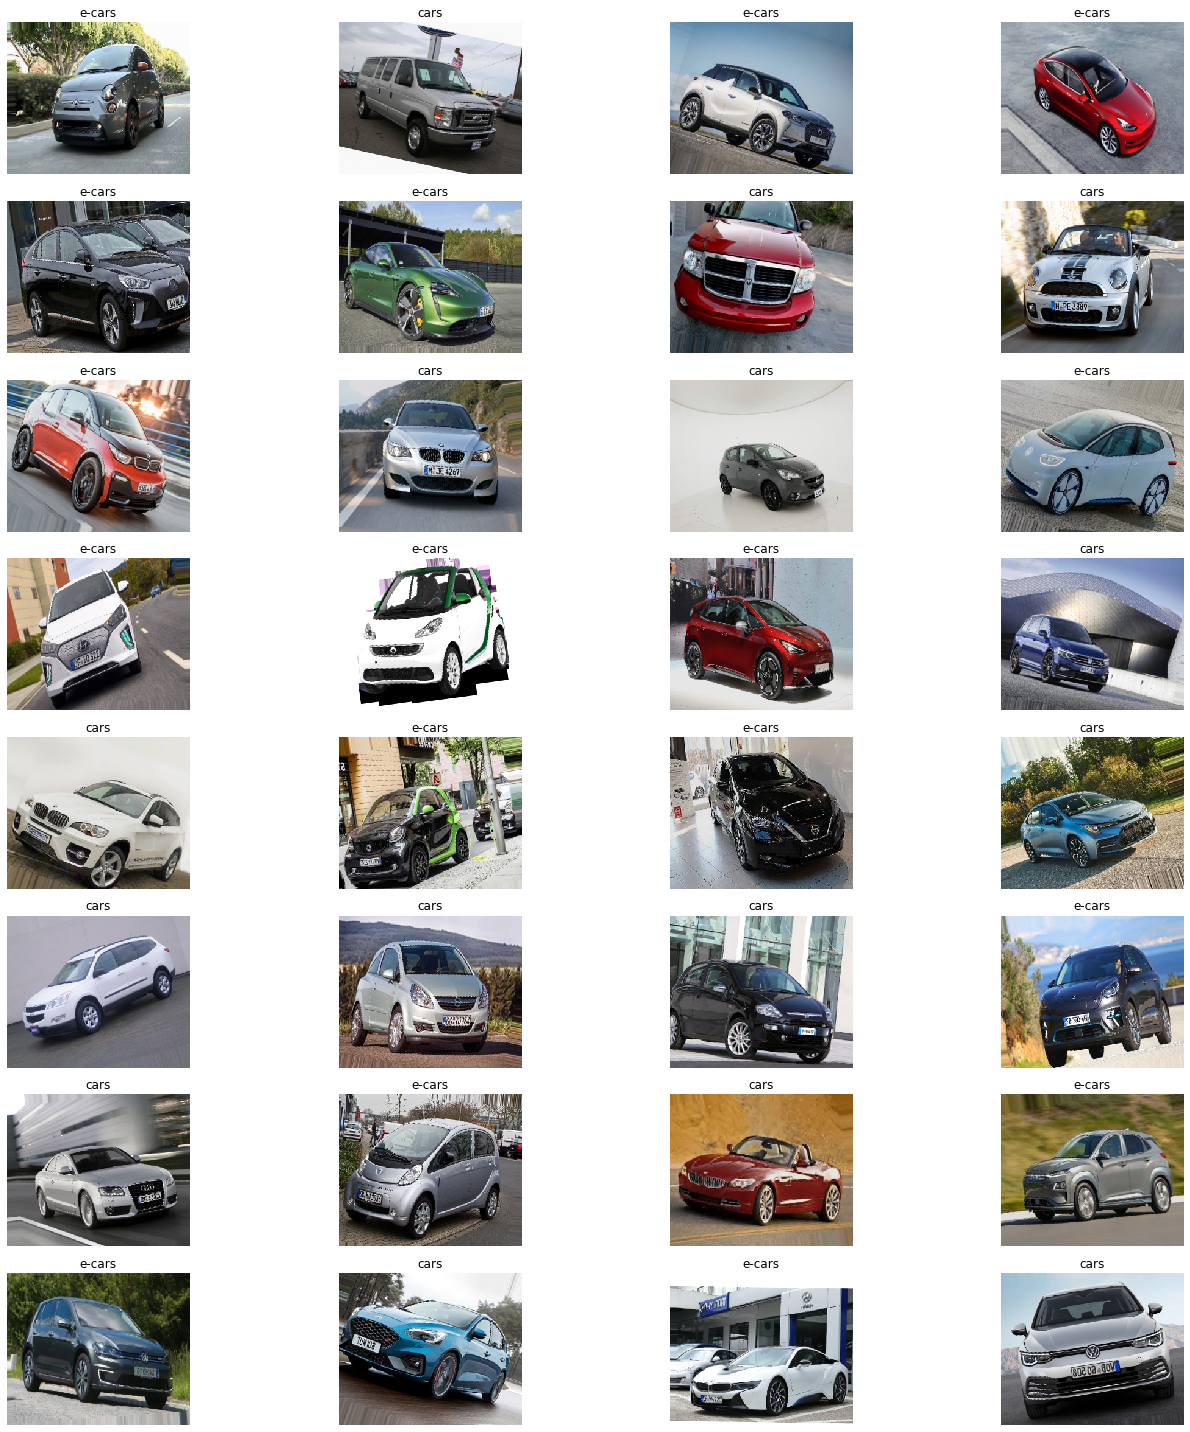

In [4]:
sample_training_images, labels = next(train_data_gen)
class_label = {v:k for k,v in train_data_gen.class_indices.items()}
fig, axes = plt.subplots(8, 4, figsize=(20,20))
axes = axes.flatten()
for img, label, ax in zip(sample_training_images, labels, axes):
    ax.set_title(class_label[np.argmax(label)])
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()

## Building the model

* Sequential model with 10 layers in total
* Input layer is a convolution layer, followed by 2 convolution layer with different filter size (the deeper the net, the higher the size)
* In total 2 pooling layer (max pooling) are implemented for parameter/data points decreasing
* For better results, 2 further convolution layers are used
* Before data is shipped to dense (fully-connected) layer, data gets flatten (from 2D to 1D)
* Output layer with 'softmax' function as activation function
* Total parameters: > 2,000,000 (other net architectures were tested with lower number of parameters, but there wasn't much difference in test accuracy)

In [5]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(12, (2, 2), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),  
    tf.keras.layers.Conv2D(24, (2, 2), activation='relu'),
    tf.keras.layers.Conv2D(32, (2, 2), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 4),
    tf.keras.layers.Conv2D(32, (2, 2), activation='relu'),
    tf.keras.layers.Conv2D(64, (2, 2), activation='relu'),    
    tf.keras.layers.MaxPooling2D(2, 4),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, 'relu'),
    tf.keras.layers.Dense(train_data_gen.num_classes, 'softmax')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 249, 299, 12)      156       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 248, 298, 24)      1176      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 247, 297, 32)      3104      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 74, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 61, 73, 32)        4128      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 60, 72, 64)        8256      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 18, 64)        0

## Training the model
* Implementation/using of some helper functions (skip_broken_images, and snapshot_callback for saving intermediate results)
* Creation and execution of fit_generator, with 25 epochs and sampels/batch_size steps per epoch

In [6]:
snapshot_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="./snapshots",
    verbose=1)

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)


def skip_broken_images(gen):
    while True:
        try:
            data, labels = next(gen)
            yield data, labels
        except GeneratorExit:
            break
        except:
            pass

In [7]:
%tensorboard --logdir logs

history = model.fit_generator(
    skip_broken_images(train_data_gen),
    steps_per_epoch= int(round(train_data_gen.samples / batch_size)),
    epochs=25,
    callbacks=[snapshot_callback, tensorboard_callback]
)

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 20160.

Epoch 1/25


C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


10/59 [====>.........................] - ETA: 2:04 - loss: 0.7681 - accuracy: 0.5281

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


14/59 [======>.......................] - ETA: 1:53 - loss: 0.7489 - accuracy: 0.5112

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


16/59 [=======>......................] - ETA: 1:51 - loss: 0.7421 - accuracy: 0.5059

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


18/59 [========>.....................] - ETA: 1:47 - loss: 0.7365 - accuracy: 0.5087

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


22/59 [==========>...................] - ETA: 1:41 - loss: 0.7288 - accuracy: 0.4986

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


26/59 [============>.................] - ETA: 1:30 - loss: 0.7230 - accuracy: 0.5108

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


30/59 [==============>...............] - ETA: 1:19 - loss: 0.7196 - accuracy: 0.5063

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


34/59 [================>.............] - ETA: 1:09 - loss: 0.7166 - accuracy: 0.5055

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


35/59 [================>.............] - ETA: 1:06 - loss: 0.7159 - accuracy: 0.5045

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


36/59 [=================>............] - ETA: 1:04 - loss: 0.7151 - accuracy: 0.5087

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


38/59 [==================>...........] - ETA: 58s - loss: 0.7140 - accuracy: 0.5058 

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


41/59 [===================>..........] - ETA: 49s - loss: 0.7125 - accuracy: 0.5038

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


43/59 [====================>.........] - ETA: 44s - loss: 0.7115 - accuracy: 0.5094

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


47/59 [======================>.......] - ETA: 32s - loss: 0.7092 - accuracy: 0.5149

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


51/59 [========================>.....] - ETA: 21s - loss: 0.7082 - accuracy: 0.5143

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


58/59 [============================>.] - ETA: 2s - loss: 0.7075 - accuracy: 0.5077

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)



Epoch 00001: saving model to ./snapshots
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./snapshots\assets
59/59 [==============================] - 160s 3s/step - loss: 0.7073 - accuracy: 0.5070
Epoch 2/25
 4/59 [=>............................] - ETA: 2:17 - loss: 0.6909 - accuracy: 0.5078

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


10/59 [====>.........................] - ETA: 2:04 - loss: 0.6925 - accuracy: 0.5156

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


12/59 [=====>........................] - ETA: 2:10 - loss: 0.6935 - accuracy: 0.5000

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


13/59 [=====>........................] - ETA: 2:07 - loss: 0.6935 - accuracy: 0.5024

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


16/59 [=======>......................] - ETA: 1:59 - loss: 0.6932 - accuracy: 0.5273

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


18/59 [========>.....................] - ETA: 1:54 - loss: 0.6932 - accuracy: 0.5191

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


20/59 [=========>....................] - ETA: 1:49 - loss: 0.6927 - accuracy: 0.5266

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


23/59 [==========>...................] - ETA: 1:40 - loss: 0.6923 - accuracy: 0.5353

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


28/59 [=============>................] - ETA: 1:24 - loss: 0.6925 - accuracy: 0.5335

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


36/59 [=================>............] - ETA: 1:04 - loss: 0.6900 - accuracy: 0.5329

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


40/59 [===================>..........] - ETA: 53s - loss: 0.6879 - accuracy: 0.5415

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


41/59 [===================>..........] - ETA: 50s - loss: 0.6901 - accuracy: 0.5350

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


43/59 [====================>.........] - ETA: 44s - loss: 0.6899 - accuracy: 0.5349

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


44/59 [=====================>........] - ETA: 42s - loss: 0.6899 - accuracy: 0.5348

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


51/59 [========================>.....] - ETA: 22s - loss: 0.6894 - accuracy: 0.5318

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


53/59 [=========================>....] - ETA: 17s - loss: 0.6889 - accuracy: 0.5330

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


56/59 [===========================>..] - ETA: 8s - loss: 0.6884 - accuracy: 0.5357 

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


58/59 [============================>.] - ETA: 2s - loss: 0.6874 - accuracy: 0.5367
Epoch 00002: saving model to ./snapshots
INFO:tensorflow:Assets written to: ./snapshots\assets
59/59 [==============================] - 169s 3s/step - loss: 0.6874 - accuracy: 0.5376
Epoch 3/25
10/59 [====>.........................] - ETA: 2:02 - loss: 0.6838 - accuracy: 0.5813

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


13/59 [=====>........................] - ETA: 1:55 - loss: 0.6805 - accuracy: 0.5986

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


22/59 [==========>...................] - ETA: 1:35 - loss: 0.6695 - accuracy: 0.6154

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


23/59 [==========>...................] - ETA: 1:34 - loss: 0.6703 - accuracy: 0.6116

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


32/59 [===============>..............] - ETA: 1:12 - loss: 0.6670 - accuracy: 0.6004

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


34/59 [================>.............] - ETA: 1:06 - loss: 0.6676 - accuracy: 0.6019

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


44/59 [=====================>........] - ETA: 41s - loss: 0.6684 - accuracy: 0.5957

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


54/59 [==========================>...] - ETA: 13s - loss: 0.6626 - accuracy: 0.5953

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


56/59 [===========================>..] - ETA: 8s - loss: 0.6609 - accuracy: 0.6015 

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


57/59 [===========================>..] - ETA: 5s - loss: 0.6626 - accuracy: 0.6002

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


58/59 [============================>.] - ETA: 2s - loss: 0.6643 - accuracy: 0.5985

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "



Epoch 00003: saving model to ./snapshots
INFO:tensorflow:Assets written to: ./snapshots\assets
59/59 [==============================] - 164s 3s/step - loss: 0.6669 - accuracy: 0.5978
Epoch 4/25
 1/59 [..............................] - ETA: 2:09 - loss: 0.6842 - accuracy: 0.6250

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


 2/59 [>.............................] - ETA: 2:06 - loss: 0.6586 - accuracy: 0.6094

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


12/59 [=====>........................] - ETA: 1:53 - loss: 0.6550 - accuracy: 0.6152

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


13/59 [=====>........................] - ETA: 1:50 - loss: 0.6557 - accuracy: 0.6134

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


16/59 [=======>......................] - ETA: 1:48 - loss: 0.6476 - accuracy: 0.6178

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


30/59 [==============>...............] - ETA: 1:14 - loss: 0.6579 - accuracy: 0.6127

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


31/59 [==============>...............] - ETA: 1:12 - loss: 0.6596 - accuracy: 0.6100

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


38/59 [==================>...........] - ETA: 54s - loss: 0.6569 - accuracy: 0.6136

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


40/59 [===================>..........] - ETA: 50s - loss: 0.6596 - accuracy: 0.6118

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


42/59 [====================>.........] - ETA: 45s - loss: 0.6586 - accuracy: 0.6125

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


43/59 [====================>.........] - ETA: 42s - loss: 0.6589 - accuracy: 0.6113

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


44/59 [=====================>........] - ETA: 40s - loss: 0.6593 - accuracy: 0.6109

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


46/59 [======================>.......] - ETA: 35s - loss: 0.6588 - accuracy: 0.6136

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


47/59 [======================>.......] - ETA: 32s - loss: 0.6589 - accuracy: 0.6131

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


48/59 [=======================>......] - ETA: 29s - loss: 0.6581 - accuracy: 0.6160

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


49/59 [=======================>......] - ETA: 26s - loss: 0.6580 - accuracy: 0.6162

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


52/59 [=========================>....] - ETA: 18s - loss: 0.6593 - accuracy: 0.6155

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


54/59 [==========================>...] - ETA: 13s - loss: 0.6611 - accuracy: 0.6148

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


57/59 [===========================>..] - ETA: 5s - loss: 0.6582 - accuracy: 0.6199

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


58/59 [============================>.] - ETA: 2s - loss: 0.6578 - accuracy: 0.6211
Epoch 00004: saving model to ./snapshots


C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


INFO:tensorflow:Assets written to: ./snapshots\assets
59/59 [==============================] - 158s 3s/step - loss: 0.6564 - accuracy: 0.6266
Epoch 5/25
 5/59 [=>............................] - ETA: 2:39 - loss: 0.6373 - accuracy: 0.6500

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


 6/59 [==>...........................] - ETA: 2:31 - loss: 0.6498 - accuracy: 0.6458

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


13/59 [=====>........................] - ETA: 2:16 - loss: 0.6504 - accuracy: 0.6418

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


20/59 [=========>....................] - ETA: 1:54 - loss: 0.6391 - accuracy: 0.6406

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


25/59 [===========>..................] - ETA: 1:40 - loss: 0.6437 - accuracy: 0.6325

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


32/59 [===============>..............] - ETA: 1:17 - loss: 0.6481 - accuracy: 0.6143

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


35/59 [================>.............] - ETA: 1:08 - loss: 0.6500 - accuracy: 0.6143

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


41/59 [===================>..........] - ETA: 50s - loss: 0.6527 - accuracy: 0.6197

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


47/59 [======================>.......] - ETA: 32s - loss: 0.6570 - accuracy: 0.6159

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


55/59 [==========================>...] - ETA: 11s - loss: 0.6567 - accuracy: 0.6172

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


58/59 [============================>.] - ETA: 2s - loss: 0.6575 - accuracy: 0.6171
Epoch 00005: saving model to ./snapshots
INFO:tensorflow:Assets written to: ./snapshots\assets
59/59 [==============================] - 167s 3s/step - loss: 0.6579 - accuracy: 0.6156
Epoch 6/25
 1/59 [..............................] - ETA: 2:09 - loss: 0.6949 - accuracy: 0.6250

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


 2/59 [>.............................] - ETA: 3:02 - loss: 0.6659 - accuracy: 0.6250

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


 4/59 [=>............................] - ETA: 2:47 - loss: 0.6733 - accuracy: 0.6094

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


 5/59 [=>............................] - ETA: 2:39 - loss: 0.6715 - accuracy: 0.6000

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


10/59 [====>.........................] - ETA: 2:21 - loss: 0.6636 - accuracy: 0.6125

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


13/59 [=====>........................] - ETA: 2:10 - loss: 0.6530 - accuracy: 0.6274

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


19/59 [========>.....................] - ETA: 1:49 - loss: 0.6518 - accuracy: 0.6283

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


24/59 [===========>..................] - ETA: 1:36 - loss: 0.6496 - accuracy: 0.6302

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


26/59 [============>.................] - ETA: 1:32 - loss: 0.6531 - accuracy: 0.6262

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


28/59 [=============>................] - ETA: 1:26 - loss: 0.6522 - accuracy: 0.6306

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


29/59 [=============>................] - ETA: 1:23 - loss: 0.6521 - accuracy: 0.6293

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


35/59 [================>.............] - ETA: 1:04 - loss: 0.6557 - accuracy: 0.6291

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


38/59 [==================>...........] - ETA: 57s - loss: 0.6566 - accuracy: 0.6263

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


39/59 [==================>...........] - ETA: 54s - loss: 0.6566 - accuracy: 0.6262

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


41/59 [===================>..........] - ETA: 49s - loss: 0.6583 - accuracy: 0.6254

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


43/59 [====================>.........] - ETA: 44s - loss: 0.6574 - accuracy: 0.6261

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


45/59 [=====================>........] - ETA: 38s - loss: 0.6582 - accuracy: 0.6204

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


46/59 [======================>.......] - ETA: 36s - loss: 0.6593 - accuracy: 0.6184

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


48/59 [=======================>......] - ETA: 30s - loss: 0.6589 - accuracy: 0.6207

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


53/59 [=========================>....] - ETA: 17s - loss: 0.6565 - accuracy: 0.6259

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


56/59 [===========================>..] - ETA: 8s - loss: 0.6555 - accuracy: 0.6281 

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


58/59 [============================>.] - ETA: 2s - loss: 0.6547 - accuracy: 0.6258
Epoch 00006: saving model to ./snapshots


C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


INFO:tensorflow:Assets written to: ./snapshots\assets
59/59 [==============================] - 173s 3s/step - loss: 0.6551 - accuracy: 0.6258
Epoch 7/25
12/59 [=====>........................] - ETA: 2:08 - loss: 0.6510 - accuracy: 0.6042

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


14/59 [======>.......................] - ETA: 2:02 - loss: 0.6432 - accuracy: 0.6250

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


18/59 [========>.....................] - ETA: 1:52 - loss: 0.6438 - accuracy: 0.6267

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


22/59 [==========>...................] - ETA: 1:40 - loss: 0.6412 - accuracy: 0.6213

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


25/59 [===========>..................] - ETA: 1:32 - loss: 0.6436 - accuracy: 0.6166

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


26/59 [============>.................] - ETA: 1:28 - loss: 0.6429 - accuracy: 0.6157

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


27/59 [============>.................] - ETA: 1:27 - loss: 0.6409 - accuracy: 0.6172

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


28/59 [=============>................] - ETA: 1:25 - loss: 0.6411 - accuracy: 0.6164

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


35/59 [================>.............] - ETA: 1:07 - loss: 0.6342 - accuracy: 0.6255

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


46/59 [======================>.......] - ETA: 36s - loss: 0.6365 - accuracy: 0.6323

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


49/59 [=======================>......] - ETA: 28s - loss: 0.6376 - accuracy: 0.6318

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


50/59 [========================>.....] - ETA: 25s - loss: 0.6380 - accuracy: 0.6310

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


53/59 [=========================>....] - ETA: 17s - loss: 0.6366 - accuracy: 0.6331

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


58/59 [============================>.] - ETA: 2s - loss: 0.6388 - accuracy: 0.6324

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)



Epoch 00007: saving model to ./snapshots
INFO:tensorflow:Assets written to: ./snapshots\assets
59/59 [==============================] - 169s 3s/step - loss: 0.6390 - accuracy: 0.6312
Epoch 8/25
 2/59 [>.............................] - ETA: 2:09 - loss: 0.6157 - accuracy: 0.7656

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


 7/59 [==>...........................] - ETA: 2:18 - loss: 0.6436 - accuracy: 0.6830

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


 8/59 [===>..........................] - ETA: 2:03 - loss: 0.6362 - accuracy: 0.6842

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


12/59 [=====>........................] - ETA: 2:10 - loss: 0.6555 - accuracy: 0.6489

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


14/59 [======>.......................] - ETA: 2:08 - loss: 0.6692 - accuracy: 0.6405

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


21/59 [=========>....................] - ETA: 1:44 - loss: 0.6614 - accuracy: 0.6429

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


23/59 [==========>...................] - ETA: 1:42 - loss: 0.6600 - accuracy: 0.6455

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


27/59 [============>.................] - ETA: 1:31 - loss: 0.6578 - accuracy: 0.6400

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


33/59 [===============>..............] - ETA: 1:14 - loss: 0.6604 - accuracy: 0.6333

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


35/59 [================>.............] - ETA: 1:09 - loss: 0.6600 - accuracy: 0.6337

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


36/59 [=================>............] - ETA: 1:06 - loss: 0.6599 - accuracy: 0.6335

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


40/59 [===================>..........] - ETA: 54s - loss: 0.6568 - accuracy: 0.6366

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


45/59 [=====================>........] - ETA: 39s - loss: 0.6527 - accuracy: 0.6424

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


52/59 [=========================>....] - ETA: 19s - loss: 0.6562 - accuracy: 0.6326

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


58/59 [============================>.] - ETA: 2s - loss: 0.6583 - accuracy: 0.6261
Epoch 00008: saving model to ./snapshots
INFO:tensorflow:Assets written to: ./snapshots\assets
59/59 [==============================] - 163s 3s/step - loss: 0.6570 - accuracy: 0.6272
Epoch 9/25
 4/59 [=>............................] - ETA: 2:13 - loss: 0.6561 - accuracy: 0.6094

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


14/59 [======>.......................] - ETA: 1:58 - loss: 0.6450 - accuracy: 0.6071

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


15/59 [======>.......................] - ETA: 1:56 - loss: 0.6457 - accuracy: 0.6083

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


16/59 [=======>......................] - ETA: 1:56 - loss: 0.6420 - accuracy: 0.6152

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


18/59 [========>.....................] - ETA: 1:58 - loss: 0.6450 - accuracy: 0.6059

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


20/59 [=========>....................] - ETA: 1:52 - loss: 0.6474 - accuracy: 0.6031

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


23/59 [==========>...................] - ETA: 1:42 - loss: 0.6402 - accuracy: 0.6182

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


32/59 [===============>..............] - ETA: 1:16 - loss: 0.6355 - accuracy: 0.6299

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


36/59 [=================>............] - ETA: 1:06 - loss: 0.6403 - accuracy: 0.6233

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


37/59 [=================>............] - ETA: 1:04 - loss: 0.6411 - accuracy: 0.6225

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


38/59 [==================>...........] - ETA: 1:01 - loss: 0.6408 - accuracy: 0.6242

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


42/59 [====================>.........] - ETA: 48s - loss: 0.6372 - accuracy: 0.6201

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


44/59 [=====================>........] - ETA: 42s - loss: 0.6387 - accuracy: 0.6196

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


55/59 [==========================>...] - ETA: 11s - loss: 0.6354 - accuracy: 0.6195

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


57/59 [===========================>..] - ETA: 5s - loss: 0.6348 - accuracy: 0.6203

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


58/59 [============================>.] - ETA: 2s - loss: 0.6368 - accuracy: 0.6182
Epoch 00009: saving model to ./snapshots


C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


INFO:tensorflow:Assets written to: ./snapshots\assets


C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


59/59 [==============================] - 171s 3s/step - loss: 0.6366 - accuracy: 0.6177
Epoch 10/25
 1/59 [..............................] - ETA: 2:11 - loss: 0.6396 - accuracy: 0.6250

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


 2/59 [>.............................] - ETA: 2:07 - loss: 0.6225 - accuracy: 0.6562

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


13/59 [=====>........................] - ETA: 1:58 - loss: 0.6314 - accuracy: 0.6514

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


15/59 [======>.......................] - ETA: 1:56 - loss: 0.6301 - accuracy: 0.6542

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


16/59 [=======>......................] - ETA: 1:55 - loss: 0.6236 - accuracy: 0.6621

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


18/59 [========>.....................] - ETA: 1:53 - loss: 0.6222 - accuracy: 0.6684

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


19/59 [========>.....................] - ETA: 1:49 - loss: 0.6168 - accuracy: 0.6743

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


27/59 [============>.................] - ETA: 1:33 - loss: 0.6168 - accuracy: 0.6725

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


32/59 [===============>..............] - ETA: 1:17 - loss: 0.6157 - accuracy: 0.6717

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


37/59 [=================>............] - ETA: 1:03 - loss: 0.6165 - accuracy: 0.6765

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


39/59 [==================>...........] - ETA: 58s - loss: 0.6201 - accuracy: 0.6721 

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


41/59 [===================>..........] - ETA: 52s - loss: 0.6217 - accuracy: 0.6706

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


42/59 [====================>.........] - ETA: 49s - loss: 0.6208 - accuracy: 0.6717

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


52/59 [=========================>....] - ETA: 20s - loss: 0.6241 - accuracy: 0.6663

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


53/59 [=========================>....] - ETA: 17s - loss: 0.6240 - accuracy: 0.6673

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


55/59 [==========================>...] - ETA: 11s - loss: 0.6235 - accuracy: 0.6674

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


56/59 [===========================>..] - ETA: 8s - loss: 0.6258 - accuracy: 0.6638 

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


58/59 [============================>.] - ETA: 2s - loss: 0.6239 - accuracy: 0.6674
Epoch 00010: saving model to ./snapshots
INFO:tensorflow:Assets written to: ./snapshots\assets
59/59 [==============================] - 173s 3s/step - loss: 0.6254 - accuracy: 0.6667


C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


Epoch 11/25
 5/59 [=>............................] - ETA: 2:04 - loss: 0.6072 - accuracy: 0.6313

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


10/59 [====>.........................] - ETA: 2:00 - loss: 0.6055 - accuracy: 0.6594

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


11/59 [====>.........................] - ETA: 1:57 - loss: 0.6043 - accuracy: 0.6676

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


22/59 [==========>...................] - ETA: 1:32 - loss: 0.6003 - accuracy: 0.6509

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


25/59 [===========>..................] - ETA: 1:26 - loss: 0.5980 - accuracy: 0.6541

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


32/59 [===============>..............] - ETA: 1:10 - loss: 0.6003 - accuracy: 0.6546

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


33/59 [===============>..............] - ETA: 1:07 - loss: 0.5962 - accuracy: 0.6595

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


34/59 [================>.............] - ETA: 1:04 - loss: 0.5963 - accuracy: 0.6613

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


40/59 [===================>..........] - ETA: 48s - loss: 0.5978 - accuracy: 0.6597

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


48/59 [=======================>......] - ETA: 28s - loss: 0.5974 - accuracy: 0.6651

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


49/59 [=======================>......] - ETA: 26s - loss: 0.5998 - accuracy: 0.6623

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


50/59 [========================>.....] - ETA: 24s - loss: 0.6027 - accuracy: 0.6597

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


52/59 [=========================>....] - ETA: 18s - loss: 0.5993 - accuracy: 0.6620

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


54/59 [==========================>...] - ETA: 13s - loss: 0.5977 - accuracy: 0.6635

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


58/59 [============================>.] - ETA: 2s - loss: 0.6003 - accuracy: 0.6630
Epoch 00011: saving model to ./snapshots
INFO:tensorflow:Assets written to: ./snapshots\assets
59/59 [==============================] - 163s 3s/step - loss: 0.5996 - accuracy: 0.6624
Epoch 12/25
 5/59 [=>............................] - ETA: 1:54 - loss: 0.6806 - accuracy: 0.6364

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


16/59 [=======>......................] - ETA: 1:49 - loss: 0.6371 - accuracy: 0.6446

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


19/59 [========>.....................] - ETA: 1:46 - loss: 0.6387 - accuracy: 0.6414

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


21/59 [=========>....................] - ETA: 1:39 - loss: 0.6387 - accuracy: 0.6429

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


23/59 [==========>...................] - ETA: 1:34 - loss: 0.6398 - accuracy: 0.6384

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


27/59 [============>.................] - ETA: 1:26 - loss: 0.6376 - accuracy: 0.6388

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


33/59 [===============>..............] - ETA: 1:10 - loss: 0.6362 - accuracy: 0.6342

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


35/59 [================>.............] - ETA: 1:05 - loss: 0.6322 - accuracy: 0.6383

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


37/59 [=================>............] - ETA: 59s - loss: 0.6314 - accuracy: 0.6384 

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


38/59 [==================>...........] - ETA: 56s - loss: 0.6298 - accuracy: 0.6431

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


39/59 [==================>...........] - ETA: 54s - loss: 0.6321 - accuracy: 0.6418

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


42/59 [====================>.........] - ETA: 46s - loss: 0.6271 - accuracy: 0.6444

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


51/59 [========================>.....] - ETA: 21s - loss: 0.6249 - accuracy: 0.6453

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


56/59 [===========================>..] - ETA: 7s - loss: 0.6265 - accuracy: 0.6457 

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


58/59 [============================>.] - ETA: 2s - loss: 0.6272 - accuracy: 0.6456
Epoch 00012: saving model to ./snapshots
INFO:tensorflow:Assets written to: ./snapshots\assets
59/59 [==============================] - 157s 3s/step - loss: 0.6264 - accuracy: 0.6457
Epoch 13/25


C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


 4/59 [=>............................] - ETA: 2:20 - loss: 0.5752 - accuracy: 0.6953

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


 9/59 [===>..........................] - ETA: 2:11 - loss: 0.6273 - accuracy: 0.6493

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


19/59 [========>.....................] - ETA: 1:46 - loss: 0.6150 - accuracy: 0.6579

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


24/59 [===========>..................] - ETA: 1:36 - loss: 0.6156 - accuracy: 0.6562

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


26/59 [============>.................] - ETA: 1:33 - loss: 0.6121 - accuracy: 0.6587

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


29/59 [=============>................] - ETA: 1:26 - loss: 0.6086 - accuracy: 0.6616

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


32/59 [===============>..............] - ETA: 1:17 - loss: 0.6072 - accuracy: 0.6611

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/59 [===============>..............] - ETA: 1:14 - loss: 0.6072 - accuracy: 0.6591

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


34/59 [================>.............] - ETA: 1:11 - loss: 0.6094 - accuracy: 0.6572

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


35/59 [================>.............] - ETA: 1:09 - loss: 0.6053 - accuracy: 0.6598

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


42/59 [====================>.........] - ETA: 49s - loss: 0.6121 - accuracy: 0.6619

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


43/59 [====================>.........] - ETA: 46s - loss: 0.6113 - accuracy: 0.6632

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


47/59 [======================>.......] - ETA: 34s - loss: 0.6065 - accuracy: 0.6694

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


53/59 [=========================>....] - ETA: 17s - loss: 0.6012 - accuracy: 0.6721

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


56/59 [===========================>..] - ETA: 8s - loss: 0.5957 - accuracy: 0.6786 

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


57/59 [===========================>..] - ETA: 5s - loss: 0.5973 - accuracy: 0.6787

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


58/59 [============================>.] - ETA: 2s - loss: 0.5975 - accuracy: 0.6783
Epoch 00013: saving model to ./snapshots
INFO:tensorflow:Assets written to: ./snapshots\assets
59/59 [==============================] - 171s 3s/step - loss: 0.5972 - accuracy: 0.6780
Epoch 14/25
 4/59 [=>............................] - ETA: 2:07 - loss: 0.6565 - accuracy: 0.6484

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


 7/59 [==>...........................] - ETA: 2:05 - loss: 0.6669 - accuracy: 0.6339

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


10/59 [====>.........................] - ETA: 2:08 - loss: 0.6852 - accuracy: 0.6187

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


15/59 [======>.......................] - ETA: 1:58 - loss: 0.6759 - accuracy: 0.6250

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


18/59 [========>.....................] - ETA: 1:51 - loss: 0.6638 - accuracy: 0.6372

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


24/59 [===========>..................] - ETA: 1:32 - loss: 0.6569 - accuracy: 0.6311

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


31/59 [==============>...............] - ETA: 1:12 - loss: 0.6469 - accuracy: 0.6421

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


34/59 [================>.............] - ETA: 1:04 - loss: 0.6457 - accuracy: 0.6415

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


36/59 [=================>............] - ETA: 1:00 - loss: 0.6453 - accuracy: 0.6415

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


39/59 [==================>...........] - ETA: 53s - loss: 0.6406 - accuracy: 0.6426

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


41/59 [===================>..........] - ETA: 47s - loss: 0.6421 - accuracy: 0.6355

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


44/59 [=====================>........] - ETA: 39s - loss: 0.6386 - accuracy: 0.6406

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


48/59 [=======================>......] - ETA: 29s - loss: 0.6369 - accuracy: 0.6393

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


52/59 [=========================>....] - ETA: 18s - loss: 0.6318 - accuracy: 0.6443

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


56/59 [===========================>..] - ETA: 7s - loss: 0.6338 - accuracy: 0.6429 

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


58/59 [============================>.] - ETA: 2s - loss: 0.6331 - accuracy: 0.6433
Epoch 00014: saving model to ./snapshots
INFO:tensorflow:Assets written to: ./snapshots\assets
59/59 [==============================] - 156s 3s/step - loss: 0.6331 - accuracy: 0.6435
Epoch 15/25


C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


 1/59 [..............................] - ETA: 3:30 - loss: 0.5333 - accuracy: 0.8125

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


 2/59 [>.............................] - ETA: 2:48 - loss: 0.5684 - accuracy: 0.7812

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


 4/59 [=>............................] - ETA: 2:48 - loss: 0.5913 - accuracy: 0.7344

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


 6/59 [==>...........................] - ETA: 2:38 - loss: 0.6014 - accuracy: 0.7083

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


 8/59 [===>..........................] - ETA: 2:42 - loss: 0.6023 - accuracy: 0.6914

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


10/59 [====>.........................] - ETA: 2:17 - loss: 0.6227 - accuracy: 0.6678

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


16/59 [=======>......................] - ETA: 1:57 - loss: 0.6018 - accuracy: 0.6839

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


23/59 [==========>...................] - ETA: 1:36 - loss: 0.5940 - accuracy: 0.6879

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


25/59 [===========>..................] - ETA: 1:32 - loss: 0.5915 - accuracy: 0.6878

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


27/59 [============>.................] - ETA: 1:26 - loss: 0.5922 - accuracy: 0.6878

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


29/59 [=============>................] - ETA: 1:21 - loss: 0.5943 - accuracy: 0.6811

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


44/59 [=====================>........] - ETA: 40s - loss: 0.5980 - accuracy: 0.6804

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


48/59 [=======================>......] - ETA: 29s - loss: 0.6020 - accuracy: 0.6757

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


49/59 [=======================>......] - ETA: 26s - loss: 0.6027 - accuracy: 0.6721

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


52/59 [=========================>....] - ETA: 18s - loss: 0.6005 - accuracy: 0.6718

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


58/59 [============================>.] - ETA: 2s - loss: 0.6056 - accuracy: 0.6728
Epoch 00015: saving model to ./snapshots
INFO:tensorflow:Assets written to: ./snapshots\assets
59/59 [==============================] - 159s 3s/step - loss: 0.6065 - accuracy: 0.6714
Epoch 16/25
 5/59 [=>............................] - ETA: 2:00 - loss: 0.5589 - accuracy: 0.7500

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


 6/59 [==>...........................] - ETA: 1:58 - loss: 0.5600 - accuracy: 0.7448

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


 7/59 [==>...........................] - ETA: 2:01 - loss: 0.5582 - accuracy: 0.7500

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


12/59 [=====>........................] - ETA: 1:53 - loss: 0.5841 - accuracy: 0.7109

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


16/59 [=======>......................] - ETA: 1:47 - loss: 0.5825 - accuracy: 0.7090

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


18/59 [========>.....................] - ETA: 1:44 - loss: 0.5802 - accuracy: 0.7135

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


21/59 [=========>....................] - ETA: 1:37 - loss: 0.5755 - accuracy: 0.7158

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


22/59 [==========>...................] - ETA: 1:34 - loss: 0.5778 - accuracy: 0.7116

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


24/59 [===========>..................] - ETA: 1:29 - loss: 0.5768 - accuracy: 0.7135

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


29/59 [=============>................] - ETA: 1:16 - loss: 0.5739 - accuracy: 0.7091

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


30/59 [==============>...............] - ETA: 1:17 - loss: 0.5718 - accuracy: 0.7094

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


36/59 [=================>............] - ETA: 1:01 - loss: 0.5785 - accuracy: 0.6997

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


43/59 [====================>.........] - ETA: 42s - loss: 0.5790 - accuracy: 0.6991

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


45/59 [=====================>........] - ETA: 36s - loss: 0.5756 - accuracy: 0.6962

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


46/59 [======================>.......] - ETA: 34s - loss: 0.5719 - accuracy: 0.7008

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


50/59 [========================>.....] - ETA: 23s - loss: 0.5727 - accuracy: 0.6991

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


51/59 [========================>.....] - ETA: 20s - loss: 0.5722 - accuracy: 0.7001

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


57/59 [===========================>..] - ETA: 5s - loss: 0.5810 - accuracy: 0.6943

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


58/59 [============================>.] - ETA: 2s - loss: 0.5805 - accuracy: 0.6953
Epoch 00016: saving model to ./snapshots
INFO:tensorflow:Assets written to: ./snapshots\assets
59/59 [==============================] - 156s 3s/step - loss: 0.5820 - accuracy: 0.6930
Epoch 17/25
 9/59 [===>..........................] - ETA: 1:56 - loss: 0.5701 - accuracy: 0.7083

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


12/59 [=====>........................] - ETA: 1:51 - loss: 0.5924 - accuracy: 0.6771

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


16/59 [=======>......................] - ETA: 1:42 - loss: 0.5989 - accuracy: 0.6699

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


18/59 [========>.....................] - ETA: 1:41 - loss: 0.5988 - accuracy: 0.6684

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


19/59 [========>.....................] - ETA: 1:38 - loss: 0.5986 - accuracy: 0.6645

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


21/59 [=========>....................] - ETA: 1:35 - loss: 0.6007 - accuracy: 0.6682

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


27/59 [============>.................] - ETA: 1:22 - loss: 0.6003 - accuracy: 0.6725

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


28/59 [=============>................] - ETA: 1:19 - loss: 0.5985 - accuracy: 0.6741

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


32/59 [===============>..............] - ETA: 1:08 - loss: 0.6001 - accuracy: 0.6738

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


33/59 [===============>..............] - ETA: 1:05 - loss: 0.6083 - accuracy: 0.6741

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


41/59 [===================>..........] - ETA: 46s - loss: 0.6022 - accuracy: 0.6760

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


43/59 [====================>.........] - ETA: 41s - loss: 0.6034 - accuracy: 0.6766

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


49/59 [=======================>......] - ETA: 25s - loss: 0.6011 - accuracy: 0.6766

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


54/59 [==========================>...] - ETA: 12s - loss: 0.5989 - accuracy: 0.6824

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


55/59 [==========================>...] - ETA: 10s - loss: 0.5995 - accuracy: 0.6813

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


57/59 [===========================>..] - ETA: 5s - loss: 0.5999 - accuracy: 0.6815

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


58/59 [============================>.] - ETA: 2s - loss: 0.5997 - accuracy: 0.6805
Epoch 00017: saving model to ./snapshots
INFO:tensorflow:Assets written to: ./snapshots\assets
59/59 [==============================] - 153s 3s/step - loss: 0.5983 - accuracy: 0.6812
Epoch 18/25
 4/59 [=>............................] - ETA: 2:19 - loss: 0.5844 - accuracy: 0.6875

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


 5/59 [=>............................] - ETA: 2:15 - loss: 0.5571 - accuracy: 0.7375

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


 6/59 [==>...........................] - ETA: 2:10 - loss: 0.5550 - accuracy: 0.7396

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


 8/59 [===>..........................] - ETA: 2:10 - loss: 0.5929 - accuracy: 0.6992

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


11/59 [====>.........................] - ETA: 2:00 - loss: 0.5936 - accuracy: 0.6875

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


12/59 [=====>........................] - ETA: 1:57 - loss: 0.5987 - accuracy: 0.6849

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


15/59 [======>.......................] - ETA: 1:55 - loss: 0.6001 - accuracy: 0.6792

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


21/59 [=========>....................] - ETA: 1:36 - loss: 0.6130 - accuracy: 0.6801

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


26/59 [============>.................] - ETA: 1:24 - loss: 0.6037 - accuracy: 0.6915

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


30/59 [==============>...............] - ETA: 1:16 - loss: 0.6029 - accuracy: 0.6953

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


31/59 [==============>...............] - ETA: 1:13 - loss: 0.6041 - accuracy: 0.6919

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


39/59 [==================>...........] - ETA: 52s - loss: 0.5941 - accuracy: 0.6959

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


42/59 [====================>.........] - ETA: 45s - loss: 0.6013 - accuracy: 0.6922

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


44/59 [=====================>........] - ETA: 39s - loss: 0.6020 - accuracy: 0.6899

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


49/59 [=======================>......] - ETA: 26s - loss: 0.6021 - accuracy: 0.6864

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


54/59 [==========================>...] - ETA: 13s - loss: 0.6009 - accuracy: 0.6841

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


58/59 [============================>.] - ETA: 2s - loss: 0.5993 - accuracy: 0.6833

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)



Epoch 00018: saving model to ./snapshots
INFO:tensorflow:Assets written to: ./snapshots\assets
59/59 [==============================] - 157s 3s/step - loss: 0.5994 - accuracy: 0.6823
Epoch 19/25
 5/59 [=>............................] - ETA: 2:10 - loss: 0.5688 - accuracy: 0.6875

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


16/59 [=======>......................] - ETA: 1:42 - loss: 0.5833 - accuracy: 0.6860

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


17/59 [=======>......................] - ETA: 1:39 - loss: 0.5824 - accuracy: 0.6880

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


19/59 [========>.....................] - ETA: 1:36 - loss: 0.5824 - accuracy: 0.6862

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


20/59 [=========>....................] - ETA: 1:36 - loss: 0.5787 - accuracy: 0.6879

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


28/59 [=============>................] - ETA: 1:17 - loss: 0.5769 - accuracy: 0.6924

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


31/59 [==============>...............] - ETA: 1:10 - loss: 0.5780 - accuracy: 0.6981

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


35/59 [================>.............] - ETA: 1:01 - loss: 0.5785 - accuracy: 0.6951

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


37/59 [=================>............] - ETA: 56s - loss: 0.5805 - accuracy: 0.6946

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


38/59 [==================>...........] - ETA: 53s - loss: 0.5842 - accuracy: 0.6919

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


39/59 [==================>...........] - ETA: 51s - loss: 0.5821 - accuracy: 0.6934

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


46/59 [======================>.......] - ETA: 33s - loss: 0.5839 - accuracy: 0.6974

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


58/59 [============================>.] - ETA: 2s - loss: 0.5756 - accuracy: 0.6989
Epoch 00019: saving model to ./snapshots
INFO:tensorflow:Assets written to: ./snapshots\assets
59/59 [==============================] - 150s 3s/step - loss: 0.5744 - accuracy: 0.6998
Epoch 20/25
 2/59 [>.............................] - ETA: 2:06 - loss: 0.5406 - accuracy: 0.7344

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


 8/59 [===>..........................] - ETA: 2:10 - loss: 0.5624 - accuracy: 0.7148

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


17/59 [=======>......................] - ETA: 1:48 - loss: 0.5664 - accuracy: 0.7096

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


18/59 [========>.....................] - ETA: 1:44 - loss: 0.5650 - accuracy: 0.7049

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


27/59 [============>.................] - ETA: 1:23 - loss: 0.5864 - accuracy: 0.6829

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


29/59 [=============>................] - ETA: 1:19 - loss: 0.5836 - accuracy: 0.6853

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


31/59 [==============>...............] - ETA: 1:14 - loss: 0.5851 - accuracy: 0.6865

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


34/59 [================>.............] - ETA: 1:06 - loss: 0.5870 - accuracy: 0.6829

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


35/59 [================>.............] - ETA: 1:03 - loss: 0.5858 - accuracy: 0.6821

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


36/59 [=================>............] - ETA: 1:01 - loss: 0.5852 - accuracy: 0.6797

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


38/59 [==================>...........] - ETA: 56s - loss: 0.5857 - accuracy: 0.6776

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


41/59 [===================>..........] - ETA: 47s - loss: 0.5835 - accuracy: 0.6791

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


45/59 [=====================>........] - ETA: 36s - loss: 0.5880 - accuracy: 0.6763

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


49/59 [=======================>......] - ETA: 26s - loss: 0.5879 - accuracy: 0.6747

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


50/59 [========================>.....] - ETA: 23s - loss: 0.5866 - accuracy: 0.6768

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


54/59 [==========================>...] - ETA: 13s - loss: 0.5854 - accuracy: 0.6800

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


58/59 [============================>.] - ETA: 2s - loss: 0.5855 - accuracy: 0.6789
Epoch 00020: saving model to ./snapshots
INFO:tensorflow:Assets written to: ./snapshots\assets
59/59 [==============================] - 155s 3s/step - loss: 0.5855 - accuracy: 0.6790


C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


Epoch 21/25
 4/59 [=>............................] - ETA: 2:10 - loss: 0.6797 - accuracy: 0.6172

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


 5/59 [=>............................] - ETA: 2:18 - loss: 0.6685 - accuracy: 0.6375

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


 6/59 [==>...........................] - ETA: 2:15 - loss: 0.6694 - accuracy: 0.6302

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


10/59 [====>.........................] - ETA: 2:08 - loss: 0.6275 - accuracy: 0.6500

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


12/59 [=====>........................] - ETA: 2:06 - loss: 0.6279 - accuracy: 0.6432

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


20/59 [=========>....................] - ETA: 1:40 - loss: 0.6201 - accuracy: 0.6562

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


21/59 [=========>....................] - ETA: 1:38 - loss: 0.6197 - accuracy: 0.6577

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


23/59 [==========>...................] - ETA: 1:35 - loss: 0.6179 - accuracy: 0.6590

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


41/59 [===================>..........] - ETA: 46s - loss: 0.5939 - accuracy: 0.6799

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


50/59 [========================>.....] - ETA: 23s - loss: 0.5920 - accuracy: 0.6832

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


51/59 [========================>.....] - ETA: 20s - loss: 0.5941 - accuracy: 0.6820

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


56/59 [===========================>..] - ETA: 7s - loss: 0.5964 - accuracy: 0.6774 

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


57/59 [===========================>..] - ETA: 5s - loss: 0.5957 - accuracy: 0.6771

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


58/59 [============================>.] - ETA: 2s - loss: 0.5949 - accuracy: 0.6767
Epoch 00021: saving model to ./snapshots
INFO:tensorflow:Assets written to: ./snapshots\assets
59/59 [==============================] - 157s 3s/step - loss: 0.5941 - accuracy: 0.6785
Epoch 22/25
 2/59 [>.............................] - ETA: 2:12 - loss: 0.6226 - accuracy: 0.6875

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


 3/59 [>.............................] - ETA: 2:16 - loss: 0.6198 - accuracy: 0.6875

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


 7/59 [==>...........................] - ETA: 2:14 - loss: 0.5951 - accuracy: 0.7009

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


13/59 [=====>........................] - ETA: 1:54 - loss: 0.5905 - accuracy: 0.6851

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


22/59 [==========>...................] - ETA: 1:32 - loss: 0.5895 - accuracy: 0.6908

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


24/59 [===========>..................] - ETA: 1:31 - loss: 0.5911 - accuracy: 0.6932

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


31/59 [==============>...............] - ETA: 1:11 - loss: 0.5840 - accuracy: 0.7002

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


35/59 [================>.............] - ETA: 1:02 - loss: 0.5789 - accuracy: 0.7042

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


38/59 [==================>...........] - ETA: 54s - loss: 0.5772 - accuracy: 0.7029

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


41/59 [===================>..........] - ETA: 47s - loss: 0.5777 - accuracy: 0.6947

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


43/59 [====================>.........] - ETA: 1:38 - loss: 0.5748 - accuracy: 0.6944

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


44/59 [=====================>........] - ETA: 1:31 - loss: 0.5782 - accuracy: 0.6920

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


53/59 [=========================>....] - ETA: 33s - loss: 0.5726 - accuracy: 0.6954

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


55/59 [==========================>...] - ETA: 21s - loss: 0.5735 - accuracy: 0.6940

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


57/59 [===========================>..] - ETA: 10s - loss: 0.5745 - accuracy: 0.6932

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


58/59 [============================>.] - ETA: 5s - loss: 0.5734 - accuracy: 0.6942 
Epoch 00022: saving model to ./snapshots


C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


INFO:tensorflow:Assets written to: ./snapshots\assets


C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


59/59 [==============================] - 309s 5s/step - loss: 0.5728 - accuracy: 0.6946
Epoch 23/25
 4/59 [=>............................] - ETA: 1:45 - loss: 0.6598 - accuracy: 0.6500

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


 5/59 [=>............................] - ETA: 1:55 - loss: 0.6515 - accuracy: 0.6591

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


11/59 [====>.........................] - ETA: 1:59 - loss: 0.6162 - accuracy: 0.6944

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


17/59 [=======>......................] - ETA: 1:47 - loss: 0.5858 - accuracy: 0.7248

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


21/59 [=========>....................] - ETA: 1:43 - loss: 0.5873 - accuracy: 0.7143

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


23/59 [==========>...................] - ETA: 1:37 - loss: 0.5827 - accuracy: 0.7203

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/59 [============>.................] - ETA: 1:28 - loss: 0.5866 - accuracy: 0.7102

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


31/59 [==============>...............] - ETA: 1:15 - loss: 0.5847 - accuracy: 0.7044

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


35/59 [================>.............] - ETA: 1:04 - loss: 0.5839 - accuracy: 0.7005

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


37/59 [=================>............] - ETA: 58s - loss: 0.5818 - accuracy: 0.7024 

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


43/59 [====================>.........] - ETA: 42s - loss: 0.5737 - accuracy: 0.7122

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


44/59 [=====================>........] - ETA: 40s - loss: 0.5744 - accuracy: 0.7116

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


46/59 [======================>.......] - ETA: 35s - loss: 0.5710 - accuracy: 0.7126

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


49/59 [=======================>......] - ETA: 26s - loss: 0.5658 - accuracy: 0.7110

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


52/59 [=========================>....] - ETA: 18s - loss: 0.5625 - accuracy: 0.7108

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


55/59 [==========================>...] - ETA: 10s - loss: 0.5672 - accuracy: 0.7083

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


56/59 [===========================>..] - ETA: 7s - loss: 0.5664 - accuracy: 0.7085 

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


58/59 [============================>.] - ETA: 2s - loss: 0.5660 - accuracy: 0.7089

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "



Epoch 00023: saving model to ./snapshots
INFO:tensorflow:Assets written to: ./snapshots\assets
59/59 [==============================] - 159s 3s/step - loss: 0.5667 - accuracy: 0.7063
Epoch 24/25
 3/59 [>.............................] - ETA: 2:12 - loss: 0.6380 - accuracy: 0.6146

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


 4/59 [=>............................] - ETA: 2:24 - loss: 0.6071 - accuracy: 0.6406

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


 5/59 [=>............................] - ETA: 2:20 - loss: 0.5889 - accuracy: 0.6562

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


23/59 [==========>...................] - ETA: 1:35 - loss: 0.5807 - accuracy: 0.6861

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


24/59 [===========>..................] - ETA: 1:34 - loss: 0.5782 - accuracy: 0.6875

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


25/59 [===========>..................] - ETA: 1:32 - loss: 0.5783 - accuracy: 0.6888

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


31/59 [==============>...............] - ETA: 1:17 - loss: 0.5715 - accuracy: 0.6935

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


41/59 [===================>..........] - ETA: 47s - loss: 0.5786 - accuracy: 0.6955

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


43/59 [====================>.........] - ETA: 42s - loss: 0.5778 - accuracy: 0.6966

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


45/59 [=====================>........] - ETA: 37s - loss: 0.5752 - accuracy: 0.6983

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


47/59 [======================>.......] - ETA: 32s - loss: 0.5723 - accuracy: 0.6992

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


51/59 [========================>.....] - ETA: 21s - loss: 0.5753 - accuracy: 0.6970

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


57/59 [===========================>..] - ETA: 5s - loss: 0.5736 - accuracy: 0.7004

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


58/59 [============================>.] - ETA: 2s - loss: 0.5723 - accuracy: 0.7024

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)



Epoch 00024: saving model to ./snapshots
INFO:tensorflow:Assets written to: ./snapshots\assets
59/59 [==============================] - 162s 3s/step - loss: 0.5718 - accuracy: 0.7016
Epoch 25/25
 2/59 [>.............................] - ETA: 2:08 - loss: 0.5985 - accuracy: 0.6719

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


 7/59 [==>...........................] - ETA: 2:06 - loss: 0.6128 - accuracy: 0.6607

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


 9/59 [===>..........................] - ETA: 2:05 - loss: 0.5917 - accuracy: 0.6771

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


11/59 [====>.........................] - ETA: 2:04 - loss: 0.5954 - accuracy: 0.6761

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


12/59 [=====>........................] - ETA: 2:01 - loss: 0.6016 - accuracy: 0.6667

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


13/59 [=====>........................] - ETA: 1:59 - loss: 0.5888 - accuracy: 0.6827

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


19/59 [========>.....................] - ETA: 1:45 - loss: 0.5671 - accuracy: 0.7105

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


22/59 [==========>...................] - ETA: 1:33 - loss: 0.5505 - accuracy: 0.7130

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


24/59 [===========>..................] - ETA: 1:28 - loss: 0.5536 - accuracy: 0.7122

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


28/59 [=============>................] - ETA: 1:18 - loss: 0.5539 - accuracy: 0.7143

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


30/59 [==============>...............] - ETA: 1:13 - loss: 0.5564 - accuracy: 0.7135

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


34/59 [================>.............] - ETA: 1:04 - loss: 0.5602 - accuracy: 0.7104

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


36/59 [=================>............] - ETA: 59s - loss: 0.5621 - accuracy: 0.7091 

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


40/59 [===================>..........] - ETA: 48s - loss: 0.5643 - accuracy: 0.7093

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


46/59 [======================>.......] - ETA: 33s - loss: 0.5647 - accuracy: 0.7091

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


48/59 [=======================>......] - ETA: 28s - loss: 0.5628 - accuracy: 0.7102

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


50/59 [========================>.....] - ETA: 23s - loss: 0.5613 - accuracy: 0.7118

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


52/59 [=========================>....] - ETA: 18s - loss: 0.5594 - accuracy: 0.7109

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


55/59 [==========================>...] - ETA: 10s - loss: 0.5569 - accuracy: 0.7136

C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:2821: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


58/59 [============================>.] - ETA: 2s - loss: 0.5607 - accuracy: 0.7117
Epoch 00025: saving model to ./snapshots
INFO:tensorflow:Assets written to: ./snapshots\assets
59/59 [==============================] - 157s 3s/step - loss: 0.5602 - accuracy: 0.7113


In [8]:
model.save('ccc_model.h5')

## Plot loss function and accuracy

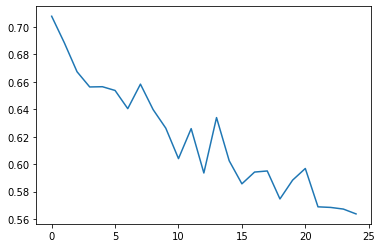

In [9]:
plt.plot(history.history['loss'])

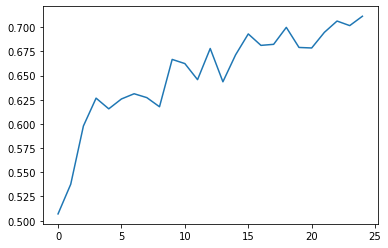

In [10]:
plt.plot(history.history['accuracy'])

## Evaluation of model
* Loading test data and performing normalization of those images (same condition like training images)
* Calculate and print test accuracy

In [11]:
test_dir = "./data_test"
test_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=test_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))

test_loss, test_acc = model.evaluate(test_data_gen)
print('\nTest accuracy: ', test_acc)

Found 195 images belonging to 2 classes.
7/7 [==============================] - 14s 2s/step - loss: 0.6937 - accuracy: 0.6359

Test accuracy:  0.63589746


C:\Users\Verena Teufl\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


## Plot confusion matrix (and classification report)

In [12]:
predictions = model.predict_generator(test_data_gen, test_data_gen.samples // batch_size+1)
pred = np.argmax(predictions, axis=1)

print('Confusion Matrix')
confusion = confusion_matrix(test_data_gen.classes, pred)
print(confusion)


print('Classification Report')
target_names = ['Cars', 'E-Cars']
print(classification_report(test_data_gen.classes, pred, target_names=target_names))

Confusion Matrix
[[34 64]
 [25 72]]
Classification Report
              precision    recall  f1-score   support

        Cars       0.58      0.35      0.43        98
      E-Cars       0.53      0.74      0.62        97

    accuracy                           0.54       195
   macro avg       0.55      0.54      0.53       195
weighted avg       0.55      0.54      0.53       195



## Plot ROC and calculate AUC

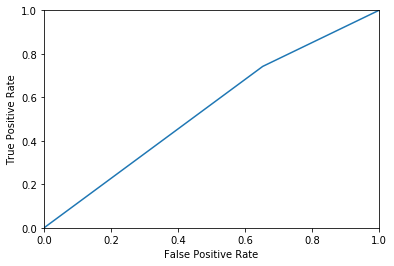

[0.         0.65306122 1.        ]
auc_score 0.5446034083736588


In [13]:
fpr , tpr , thresholds = roc_curve ( test_data_gen.classes , pred)

# function for plotting ROC curve
def plot_roc_curve(fpr,tpr): 
  plt.plot(fpr,tpr) 
  plt.axis([0,1,0,1]) 
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.show()    
  print(fpr)
    
# call function    
plot_roc_curve (fpr,tpr) 

# calculate and plot AUC
print('auc_score', roc_auc_score(test_data_gen.classes, pred))